In [14]:
# Importa le librerie necessarie
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import random
from skimage.util import random_noise
from os import listdir
import tarfile
import zipfile
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.data.experimental import AUTOTUNE
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Conv2D, Add, ReLU, Concatenate, GlobalAveragePooling2D, Multiply, Input, Lambda,  MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds
from tensorflow.keras.saving import register_keras_serializable
from keras.models import load_model
from sklearn.model_selection import train_test_split
from io import BytesIO


In [4]:
# MeanShift: sottrae (o aggiunge) la media RGB
@register_keras_serializable("MeanShift")
class MeanShift(Layer):
    def __init__(self, rgb_mean, sign=-1, **kwargs):
        """
        rgb_mean: tupla con la media dei canali R, G, B.
        sign: -1 per sottrarre la media, 1 per aggiungerla.
        """
        super(MeanShift, self).__init__(**kwargs)
        self.rgb_mean = tf.constant(rgb_mean, dtype=tf.float32)
        self.sign = sign

    def call(self, x):
        # x è atteso in formato (batch, altezza, larghezza, 3)
        # Sfruttiamo Lambda per eseguire l'operazione per ogni elemento
        # Nota: non stiamo scalando per std in questo esempio
        return x + self.sign * self.rgb_mean

# BasicBlock: Conv2D seguita da attivazione ReLU
@register_keras_serializable("BasicBlock")
class BasicBlock(Layer):
    def __init__(self, out_channels, kernel_size=3, stride=1, use_bias=False, **kwargs):
        super(BasicBlock, self).__init__(**kwargs)
        self.conv = Conv2D(out_channels, kernel_size, strides=stride,
                           padding='same', use_bias=use_bias)
        self.relu = ReLU()

    def call(self, x):
        return self.relu(self.conv(x))

# ResidualBlock: due convoluzioni con skip connection(come lavora cuda con 2 thread -> 2 filtri applicati e poi si uniscono i risultati)
@register_keras_serializable("ResidualBlock")
class ResidualBlock(Layer):
    def __init__(self, out_channels, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = Conv2D(out_channels, 3, strides=1, padding='same')
        self.relu = ReLU()
        self.conv2 = Conv2D(out_channels, 3, strides=1, padding='same')

    def call(self, x):
        residual = self.conv1(x)
        residual = self.relu(residual)
        residual = self.conv2(residual)
        out = Add()([x, residual])
        return ReLU()(out)

# EResidualBlock: versione estesa con convoluzioni a gruppi
@register_keras_serializable("EResidualBlock")
class EResidualBlock(Layer):
    def __init__(self, out_channels, groups=1, **kwargs):
        super(EResidualBlock, self).__init__(**kwargs)
        self.conv1 = Conv2D(out_channels, 3, strides=1, padding='same', groups=groups)
        self.relu = ReLU()
        self.conv2 = Conv2D(out_channels, 3, strides=1, padding='same', groups=groups)
        self.conv3 = Conv2D(out_channels, 1, strides=1, padding='valid')

    def call(self, x):
        residual = self.conv1(x)
        residual = self.relu(residual)
        residual = self.conv2(residual)
        residual = self.relu(residual)
        residual = self.conv3(residual)
        out = Add()([x, residual])
        return ReLU()(out)

# Merge_Run_dual: due rami convoluzionali con dilatazioni diverse, poi fusione e skip connection
@register_keras_serializable("MergeRunDual")
class MergeRunDual(Layer):
    def __init__(self, out_channels, **kwargs):
        super(MergeRunDual, self).__init__(**kwargs)
        # Primo ramo
        self.conv1a = Conv2D(out_channels, 3, strides=1, padding='same')
        self.relu1a = ReLU()
        self.conv1b = Conv2D(out_channels, 3, strides=1, padding='same', dilation_rate=2)
        self.relu1b = ReLU()
        # Secondo ramo
        self.conv2a = Conv2D(out_channels, 3, strides=1, padding='same', dilation_rate=3)
        self.relu2a = ReLU()
        self.conv2b = Conv2D(out_channels, 3, strides=1, padding='same', dilation_rate=4)
        self.relu2b = ReLU()
        # Gogeta
        self.conv3 = Conv2D(out_channels, 3, strides=1, padding='same')
        self.relu3 = ReLU()

    def call(self, x):
        branch1 = self.relu1a(self.conv1a(x))
        branch1 = self.relu1b(self.conv1b(branch1))

        branch2 = self.relu2a(self.conv2a(x))
        branch2 = self.relu2b(self.conv2b(branch2))

        merged = Concatenate()([branch1, branch2])
        merged = self.relu3(self.conv3(merged))
        return Add()([merged, x])

# CALayer: Channel Attention Layer
@register_keras_serializable("CALayer")
class CALayer(Layer):
    def __init__(self, channel, reduction=16, **kwargs):
        super(CALayer, self).__init__(**kwargs)
        self.channel = channel
        self.reduction = reduction
        self.conv1 = Conv2D(channel // reduction, 1, strides=1, padding='same')
        self.relu = ReLU()
        self.conv2 = Conv2D(channel, 1, strides=1, padding='same', activation='sigmoid') #sigmoid: risultato tra 0 e 1

    def call(self, x):
        # Calcolo della media globale per canale
        y = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
        y = self.relu(self.conv1(y))
        y = self.conv2(y)
        return Multiply()([x, y])

# Block: combinazione di MergeRunDual, ResidualBlock, EResidualBlock e CALayer
@register_keras_serializable("Block")
class Block(Layer):
    def __init__(self, out_channels, **kwargs):
        super(Block, self).__init__(**kwargs)
        self.merge_run_dual = MergeRunDual(out_channels)
        self.residual_block = ResidualBlock(out_channels)
        self.e_residual_block = EResidualBlock(out_channels)
        self.ca = CALayer(out_channels)

    def call(self, x):
        r1 = self.merge_run_dual(x)
        r2 = self.residual_block(r1)
        r3 = self.e_residual_block(r2)
        out = self.ca(r3)
        return out

# RIDNET: il modello final
@register_keras_serializable("RIDNET")
def RIDNET(n_feats=64, rgb_range=1.0):
    """
    n_feats: numero di feature channels usate all'interno del modello.
    rgb_range: scala dei valori RGB (ad es. 1.0 se l'input è normalizzato [0,1]).
    """
    rgb_mean = (0.4488, 0.4371, 0.4040)

    input_layer = Input(shape=(None, None, 3))

    # Sottosottrai la media (MeanShift con sign=-1)
    sub_mean = MeanShift(rgb_mean, sign=-1)
    x = sub_mean(input_layer)

    # Testa: BasicBlock (conv + ReLU)
    head = Conv2D(n_feats, 3, strides=1, padding='same', activation='relu')(x)

    # Serie di blocchi
    b1 = Block(n_feats)(head)
    b2 = Block(n_feats)(b1)
    b3 = Block(n_feats)(b2)
    b4 = Block(n_feats)(b3)

    # Coda: convoluzione finale per ottenere 3 canali
    tail = Conv2D(3, 3, strides=1, padding='same')(b4)

    # Aggiungi la media (MeanShift con sign=+1)
    add_mean = MeanShift(rgb_mean, sign=1)
    res = add_mean(tail)

    # Connessione residua a livello di immagine: somma con l'input originale
    output = Add()([res, input_layer])

    model = Model(inputs=input_layer, outputs=output)
    return model

In [2]:
def extract_kvasir_zip(zip_path, extract_path="./kvasir_seg"):
    """
    Estrae un file ZIP contenente il dataset Kvasir.
    """
    os.makedirs(extract_path, exist_ok=True)

    print("Estrazione del dataset...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(path=extract_path)
    print("Estrazione completata!")

def load_kvasir_images(dataset_path, img_size=(224, 224)):
    """
    Carica le immagini dal dataset estratto.
    """
    images = []

    for img in listdir(dataset_path):
        img_path = dataset_path + "/" + img
        imgs = load_img(img_path, target_size=img_size)
        img_array = img_to_array(imgs).astype('float32') / 255.0  # Normalizzazione
        images.append(img_array)

    return np.array(images)

def split_dataset(images, labels=None, test_size=0.2, val_size=0.1):
    """
    Suddivide il dataset in training, validation e test set.
    """
    # If labels are not provided, assume unsupervised learning and create dummy labels
    if labels is None:
        labels = np.zeros(len(images))  # Create dummy labels for unsupervised task

    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size / (1 - test_size), random_state=42)

    return x_train, x_val, x_test, y_train, y_val, y_test


In [3]:
def add_random_noise(tensor_image):
    """
    Aggiunge rumore casuale a un'immagine convertendo il tensore in NumPy.
    """
    numpy_image = tensor_image.numpy()

    # Genera un noise_factor casuale tra 0.1 e 0.9
    noise_factor = np.random.uniform(0.1, 0.9)

    # Scegli il tipo di rumore
    noise_types = ['gaussian', 'salt', 'pepper', 's&p', 'speckle', 'poisson']
    noise_type = random.choice(noise_types)

    # Applica il rumore
    noisy_img = random_noise(numpy_image, mode=noise_type, clip=True) * (1 - noise_factor) + noise_factor * np.random.rand(*numpy_image.shape)

    # Converti di nuovo in tf.Tensor
    return tf.convert_to_tensor(noisy_img, dtype=tf.float32)

# Wrapper compatibile con tf.data.Dataset.map()
def add_random_noise_tf(tensor_image):
    noisy_image = tf.py_function(func=add_random_noise, inp=[tensor_image], Tout=tf.float32)

    # Impostiamo la forma esplicitamente per evitare problemi con tf.data
    noisy_image.set_shape(tensor_image.shape)

    return noisy_image  # Restituiamo solo l'immagine rumorosa

In [5]:
def plot_side_by_side(x_noisy, x_original, n=10):
    """
    Visualizza n coppie di immagini affiancando l'immagine rumorosa e quella originale per immagini a colori.
    """
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Immagine rumorosa
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_noisy[i])
        plt.title("Rumorosa")
        plt.axis('off')

        # Immagine originale
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(x_original[i])
        plt.title("Originale")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:

def plot_denoising_results(x_test_noisy, decoded_imgs, x_test, n=10):
    """
    Visualizza n immagini rumorose, le rispettive immagini denoised e quelle originali.
    """
    plt.figure(figsize=(20, 4))
    n = 10
    for i in range(n):
        # Immagine rumorosa
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test_noisy[i])
        plt.title("Rumorosa")
        plt.axis('off')
        # Immagine denoised
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.title("Denoised")
        plt.axis('off')
        # Immagine originale
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(x_test[i])
        plt.title("Originale")
        plt.axis('off')
    plt.tight_layout()
    plt.show()



In [7]:
def plot_side_by_side(x_noisy, x_original, n=10):
    """
    Visualizza n coppie di immagini affiancando l'immagine rumorosa e quella originale per immagini a colori.
    """
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Immagine rumorosa
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_noisy[i])
        plt.title("Rumorosa")
        plt.axis('off')

        # Immagine originale
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(x_original[i])
        plt.title("Originale")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [8]:
zip_path = "./kvasir-seg.zip"  # Percorso del file ZIP
extract_kvasir_zip(zip_path)

Estrazione del dataset...
Estrazione completata!


In [9]:
kvasir_dataset = load_kvasir_images("./kvasir_seg/Kvasir-SEG/images")

In [10]:
x_train_k, x_val_k, x_test_k, y_train_k, y_val_k, y_test_k = split_dataset(kvasir_dataset)

In [15]:
# Aggiungi rumore alle immagini
x_train_noisy_k      = add_random_noise_tf(x_train_k)
x_test_noisy_k       = add_random_noise_tf(x_test_k)
x_validation_noisy_k = add_random_noise_tf(x_val_k)

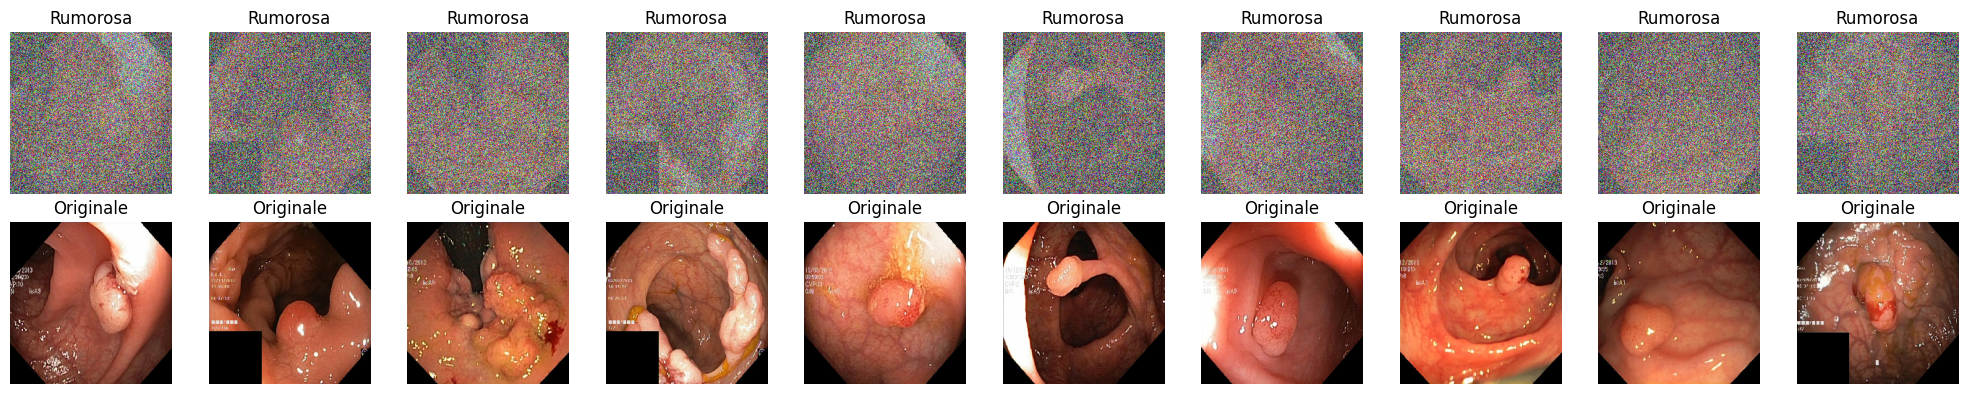

In [16]:
plot_side_by_side(x_test_noisy_k, x_test_k, n=10)

In [17]:
ridnet = load_model('new_RIDNET.keras')
autoencoder = load_model('new_autoencoder.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'block_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'block_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'block_6', however the layer does not have a `buil

In [18]:
ridnet_result = ridnet.predict(x_test_noisy_k)

7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 977ms/step


In [19]:
autoencoder_result = autoencoder.predict(x_test_noisy_k)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step


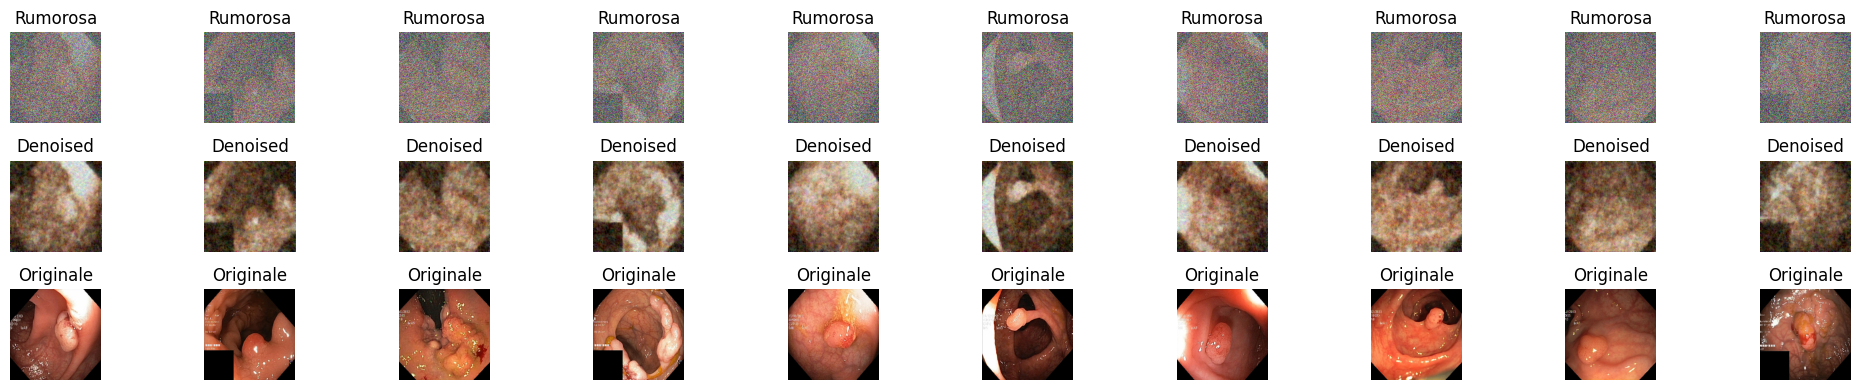

In [20]:
plot_denoising_results(x_test_noisy_k, ridnet_result, x_test_k, n=10)

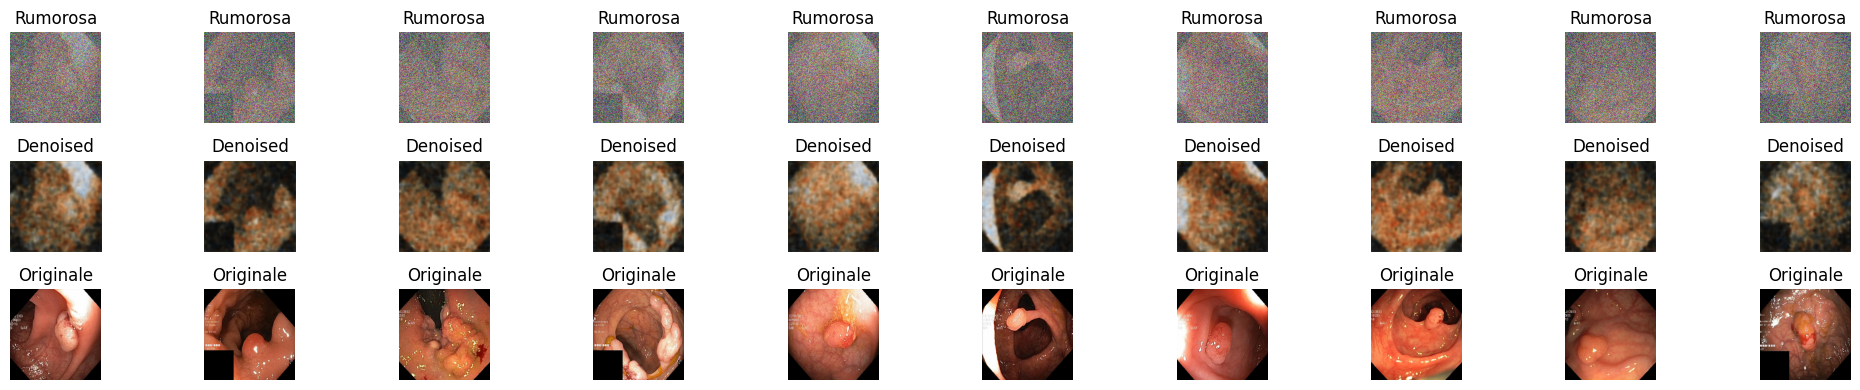

In [21]:
plot_denoising_results(x_test_noisy_k, autoencoder_result, x_test_k, n=10)

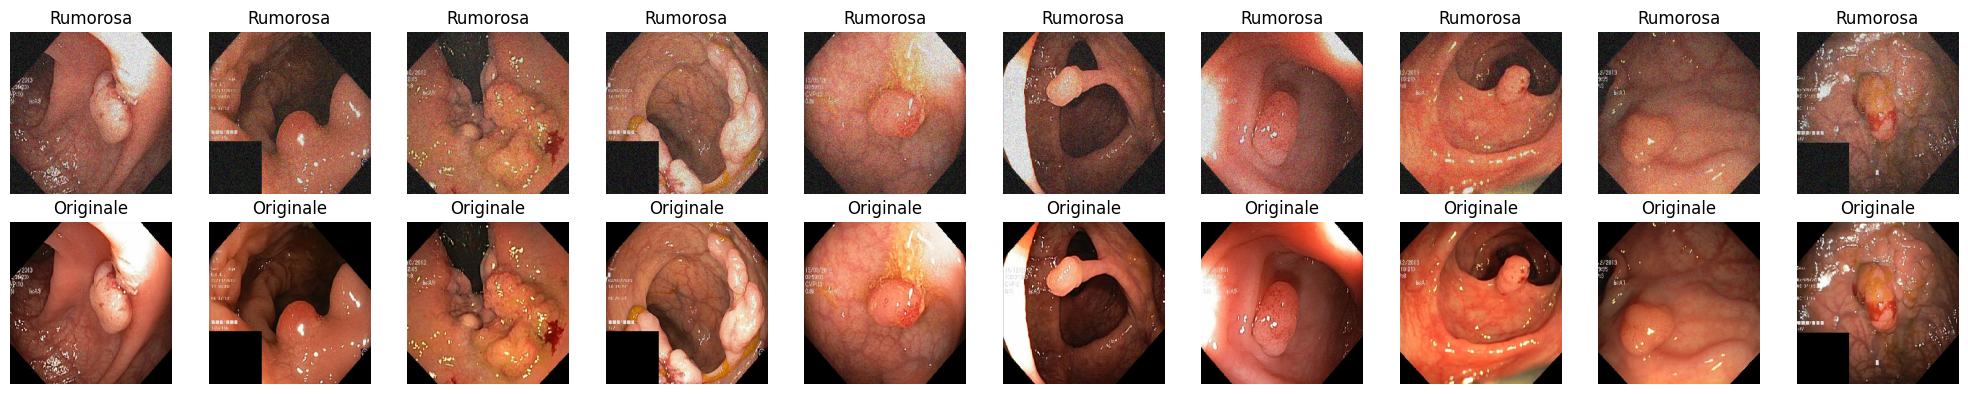

In [22]:
x_train_noisy_k      = add_random_noise_tf(x_train_k)
x_test_noisy_k       = add_random_noise_tf(x_test_k)
x_validation_noisy_k = add_random_noise_tf(x_val_k)
plot_side_by_side(x_test_noisy_k, x_test_k, n=10)

In [23]:
ridnet_result = ridnet.predict(x_test_noisy_k)
autoencoder_result = autoencoder.predict(x_test_noisy_k)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 352ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


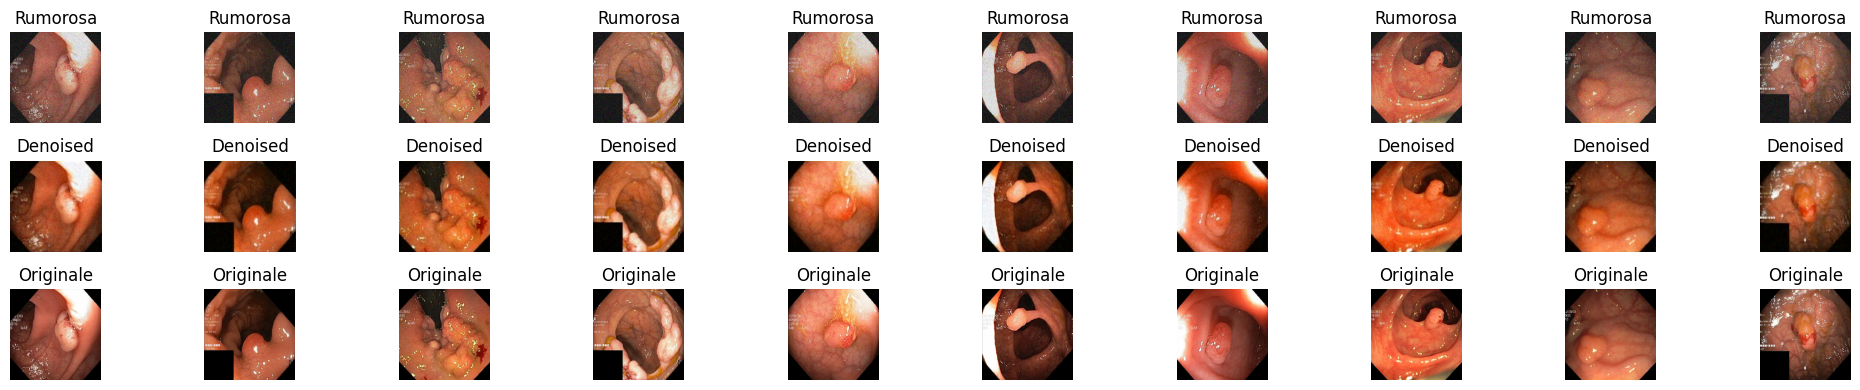

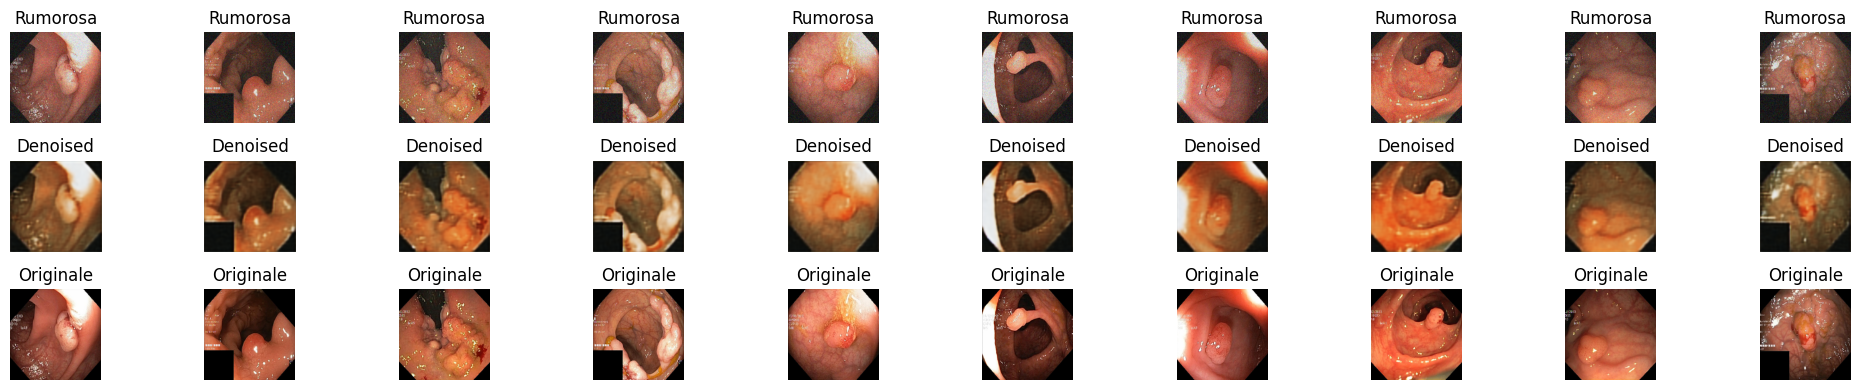

In [24]:
plot_denoising_results(x_test_noisy_k, ridnet_result, x_test_k, n=10)
plot_denoising_results(x_test_noisy_k, autoencoder_result, x_test_k, n=10)